In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from time import time

### Black Scholes

$S_t$ - stock price at time t

$K$ - strike / exercise price

$\sigma$ - stock price volatility

$r$ - risk-free interest rate

$T$ - maturity

$q$ - dividend rate

Define useful functions

\begin{equation}
d_1  =\frac{1}{\sigma \sqrt{T-t}}\left[\ln \left(\frac{S_t}{K}\right)+\left(r - q +\frac{\sigma^2}{2}\right)(T-t)\right]
\end{equation}

\begin{equation}
d_2 =d_{1}-\sigma \sqrt{T-t}
\quad or\quad
d_{2}  =\frac{1}{\sigma \sqrt{T-t}}\left[\ln \left(\frac{S_t}{K}\right)+\left(r- q - \frac{\sigma^2}{2}\right)(T-t)\right]
\end{equation}

$$
N(x)=\frac{1}{\sqrt{2 \pi}} \int_{-\infty}^x e^{-z^2 / 2} d z
$$

$$
n(x)= N' (x) = \frac{1}{\sqrt{2 \pi}} e^{-x^2 / 2}
$$

Call price
\begin{equation}
C(S_t, t) = N(d_1) S_t e^{-q(T-t)} - N(d_2) K e^{-r(T-t)}
\end{equation}

Digital Call price

\begin{equation}
DC(S_t, t) = e^{-r(T-t)} N(d_2)
\end{equation}

Put price
\begin{equation}
P\left(S_t, t\right)  =K e^{-r(T-t)}- S_te^{-q(T-t)} +C\left(S_t, t\right) =\\
 =N\left(-d_2\right) K e^{-r(T-t)}-N\left(-d_1\right) S_te^{-q(T-t)}
\end{equation}

Digital Put price

\begin{equation}
DP\left(S_t, t\right)=N\left(-d_2\right) e^{-r(T-t)}
\end{equation}


Put - Call parity

\begin{equation}
C(S_t, t) - P\left(S_t, t\right) = S_te^{-q(T-t)} -  K e^{-r(T-t)},
\end{equation}

where

\begin{equation}
FC(S_t,t) = S_te^{-q(T-t)} -  K e^{-r(T-t)},
\end{equation}

is the value of a forward contract with strike $K$.

The value of a zero coupon bond is

\begin{equation}
ZeroCouponBond(T,t) = e^{-r(T-t)}.
\end{equation}


In [ ]:
def d1(St, K, T, t, r, q, sigma):
    return (np.log(St/K) + (r -q + sigma**2/2)*(T-t))/(sigma*np.sqrt(T - t))

def d2(St, K, T, t, r, q, sigma):
    return (np.log(St/K) + (r - q - sigma**2/2)*(T-t))/(sigma*np.sqrt(T - t))

def BSMcall(St, K, T, t, r, q, sigma):
    """
    St: Stock price at time t
    t: reference time
    T: time to maturity
    r: risk free rate
    q : dividend rate
    sigma: volatility
    """
    _d1 = sp.special.ndtr(d1(St, K, T, t, r, q, sigma))
    _d2 = sp.special.ndtr(d2(St, K, T, t, r, q, sigma))

    return St*np.exp(-q*(T-t))*_d1 - K*np.exp(-r*(T-t))*_d2

def BSMdigitalCall(St, K, T, t, r, q, sigma):
    return np.exp(-r*(T-t))*sp.special.ndtr(d2(St, K, T, t, r, q, sigma))

def BSMput(St, K, T, t, r, q, sigma):
    _d1 = sp.special.ndtr(-d1(St, K, T, t, r, q, sigma))
    _d2 = sp.special.ndtr(-d2(St, K, T, t, r, q, sigma))

    return K*np.exp(-r*(T-t))*_d2 - St*np.exp(-q*(T-t))*_d1

def BSMdigitalPut(St, K, T, t, r, q, sigma):
    return np.exp(-r*(T-t))*sp.special.ndtr(-d2(St, K, T, t, r, q, sigma))

def BSMforwardPrice(St, K, T, t, r, q):
    return St*np.exp(-q*(T-t)) - K*np.exp(-r*(T-t))

def BSMzeroCouponBondPrice(T, t, r):
    return np.exp(-r*(T-t))


1D Geometric Brownian Motion generator
$$
S_T=S_0 e^{(r-d) T-\frac{1}{2} \sigma^2 T+\sigma \sqrt{T} W}
$$

In [ ]:
def OneDGBMPathGenerator(d,S0,T,r,q,sigma):
    """
    d : number of paths
    S0: initial stock price
    T : maturity
    r : risk free interest rate
    q : divident rate
    sigma : stock volatility
    """
    return S0*np.exp((r-q-sigma**2/2)*np.repeat(np.array([T]),d) + sigma*np.sqrt(T)*np.random.normal(size=(d)))

Multi dimensional Geometric Brownian Motion generator

$$\Delta T = T/N $$, where $N$ is the number of time steps.

$$S_{(j+1)\Delta T} = S_{j\Delta T} + rS_{j\Delta T} \Delta T + \sigma S_{j\Delta T} \sqrt{\Delta T} W_j$$

In [ ]:
def GBMPathGenerator(n,d,S0,T,r,q,sigma):
        """
        n : dimensionality / number of increments
        d : number of paths
        S0: initial stock price
        T : maturity
        r : risk free interest rate
        q : divident rate
        sigma : stock volatility
        """
        times = np.linspace(0., T, n)
        dt = times[1] - times[0]
        timesArray = np.array([times for i in range(d)]).transpose()
        # Bt2 - Bt1 ~ Normal with mean 0 and variance t2-t1
        dB = np.zeros((n, d))
        dB[1:, :] = np.sqrt(dt) * np.random.normal(size=(n-1, d))
        # Simulation of Arithmetic brownian motion
        B = np.cumsum(dB, axis=0)
        S = S0*np.exp((r-q-sigma**2/2)*timesArray + sigma*B)
        return S


In [ ]:
# Pricing the Monte Carlo call
def MonteCarloCall(S, K, T, t):
    """
    S: numpy array. These are the price paths of the stock price
    K: strike price
    T: maturity
    t: reference time
    dt: time step
    """
    if(S.ndim == 1):
        return np.mean(np.maximum(S - K,0))*np.exp(-r*(T-t))

    if(S.ndim == 2):
        dt = T/(S.shape[0]-1)
        t_idx = int(np.rint((T-t)/dt))
        return np.mean(np.maximum(S[t_idx,:] - K,0))*np.exp(-r*(T-t))

def MonteCarloDigitalCall(S, K, T, t):
    """
    S: numpy array. These are the price paths of the stock price
    K: strike price
    """

    if(S.ndim == 1):
        return np.mean(S - K > 0)*np.exp(-r*(T-t))

    if(S.ndim == 2):
        dt = T/(S.shape[0]-1)
        t_idx = int(np.rint((T-t)/dt))
        return np.mean(S[t_idx,:] > K)*np.exp(-r*(T-t))


def MonteCarloPut(S, K, T, t):
    """
    S: numpy array. These are the price paths of the stock price
    K: strike price
    """

    if(S.ndim == 1):
        return np.mean(np.maximum(K - S,0))*np.exp(-r*(T-t))

    if(S.ndim ==2):
        dt = T/(S.shape[0]-1)
        t_idx = int(np.rint((T-t)/dt))
        return np.mean(np.maximum(K - S[t_idx,:],0))*np.exp(-r*(T-t))

def MonteCarloDigitalPut(S, K, T, t):
    """
    S: numpy array. These are the price paths of the stock price
    K: strike price
    """

    if(S.ndim == 1):
        return np.mean(K - S > 0)*np.exp(-r*(T-t))

    if(S.ndim == 2):
        dt = T/(S.shape[0]-1)
        t_idx = int(np.rint((T-t)/dt))
        return np.mean(S[t_idx,:] < K)*np.exp(-r*(T-t))

def MonteCarloZeroCouponBond(S, K, T, t):
    """
    S: numpy array. These are the price paths of the stock price
    K: strike price
    """
    return MonteCarloDigitalPut(S, K, T, t) + MonteCarloDigitalCall(S, K, T, t)

def MonteCarloForwardPrice(S, K, T, t):
    """
    S: numpy array. These are the price paths of the stock price
    K: strike price
    """
    if(S.ndim == 1):
        return np.mean(S - K)*np.exp(-r*(T-t))

    if(S.ndim == 2):
        dt = T/(S.shape[0]-1)
        t_idx = int(np.rint((T-t)/dt))
        return np.mean(S[t_idx,:] - K)*np.exp(-r*(T-t))

### Consistency tests

In [ ]:
t = 0 # Reference time
T = 5 # Maturity
K = 103 # Strike
q = 0.1 # Dividend rate
sigma = .08 # Volatility
r = .05 # Risk free interest rate
S0 = 100 # Initial Stock Price

1. Put call parity : call - put = forward

In [ ]:
putCallparityiscrepancy = (BSMcall(S0, K, T, t, r, q, sigma) - BSMput(S0, K, T, t, r, q, sigma) - BSMforwardPrice(S0, K, T, t, r, q))/BSMforwardPrice(S0, K, T, t, r, q)
print(f'The discrepancy of Put Call parity to Forward Contract price is {putCallparityiscrepancy*100:.2f} %')

The discrepancy of Put Call parity to Forward Contract price is -0.00 %


2. Price of a call is monotonously decreasing with K

3. A call option price should be between $S(t)e^{-q(T-t)}$ and $S(t)e^{-q(T-t)} - Ke^{-r(T-t)}$

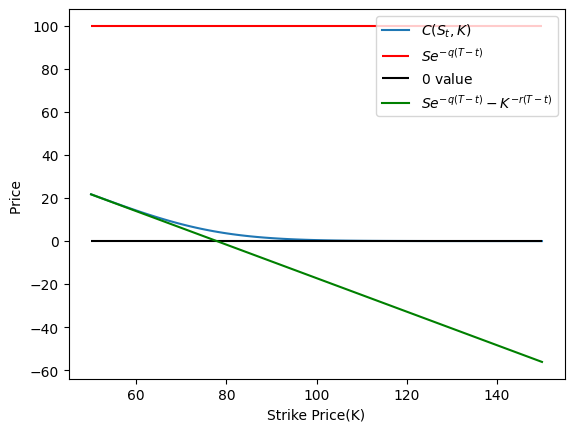

In [ ]:
kVec = np.linspace(50, 150, 100)
StKVec = BSMcall(S0, kVec, T, t, r, q, sigma)
fig,ax = plt.subplots()
ax.plot(kVec,StKVec, label="$C(S_t,K)$")
ax.set_xlabel('Strike Price(K)')
ax.set_ylabel('Price ')
ax.hlines(y=S0, xmin=kVec[0], xmax = kVec[-1], colors='red', label="$Se^{-q(T-t)}$")
ax.hlines(y=0, xmin=kVec[0], xmax = kVec[-1], colors='black', label="$0$ value")
ax.plot(kVec, S0*np.exp(-q*(T-t)) - np.exp(-r*(T-t))*kVec, color='green', label="$Se^{-q(T-t)}-K^{-r(T-t)}$")
ax.legend()
fig.show()

4. For non dividend yielding stock the value of a call option is increasing with maturity

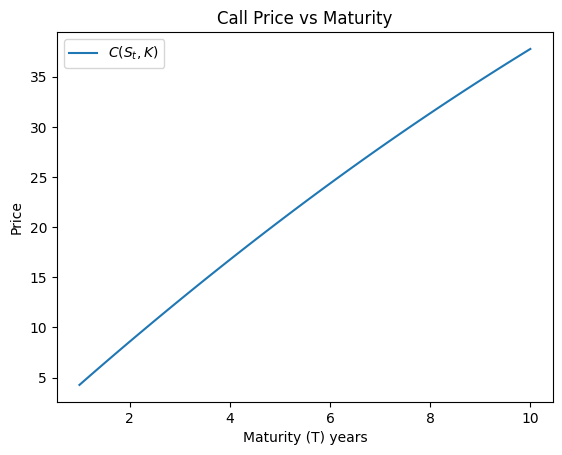

In [ ]:
TVec = np.linspace(1, 10, 100)
StvsT = BSMcall(St = S0, K = K, T = TVec, t = t, r = r, q = 0, sigma = sigma)
fig,ax = plt.subplots()
ax.plot(TVec,StvsT, label="$C(S_t,K)$")
ax.set_xlabel('Maturity (T) years')
ax.set_ylabel('Price')
ax.set_title('Call Price vs Maturity')
ax.legend()

5. The call option is convex w.r.t. strike price

We call a function $g(x)$ convex if
$$g(\lambda x+(1-\lambda) y) \leq \lambda g(x)+(1-\lambda) g(y)$$

for any $x$,$y$ and $0 < \lambda < 1$.

In [ ]:
# The notConvex function looks for counterexamples of the function being convex
def notConvex(fun, bounds, maxTime=1):
    eps = 1e-6
    t0 = time()
    no_samples = 0
    while time() - t0 < maxTime:
        sampleBounds = np.random.uniform(bounds[0], bounds[1], 2)
        x = np.min(sampleBounds)
        y = np.max(sampleBounds)
        _lambda = (np.random.rand()+1)/2
        if(fun(_lambda*x + (1-_lambda)*y) -(_lambda*fun(x) + (1-_lambda)*fun(y)) > eps):
            return True
        no_samples += 1
    print(f'No of samples: {no_samples}')
    return False

In [ ]:
_callConvexity = notConvex(lambda x: BSMcall(S0, x, T, t, r, q, sigma), (1,200))
print(f'The call option is convex w.r.t. strike price: {not _callConvexity}')

No of samples: 16191
The call option is convex w.r.t. strike price: True


6. The call spread is roughly equal to a digital Call

The call spread is computed by buying a call for a lower strike, say $K - ϵ$, and selling a call for higher price, $K$. In other words, the call spread is related to the the first derivative of call price w.r.t strike $K$

For long maturities and tight call spreads, the approximation turns into an equality

In [ ]:
eps = 1e-5
maturity = 5
callSpread = (BSMcall(St = S0, K = K-eps, T = maturity, t = t, r = r, q = q, sigma = sigma) - BSMcall(St = S0, K = K, T = maturity, t = t, r = r, q = q, sigma = sigma))/eps
callSpreadDiscrepancy = (callSpread - BSMdigitalCall(St = S0, K = K, T = maturity, t = t, r = r, q = q, sigma = sigma))/BSMdigitalCall(St = S0, K = K, T = maturity, t = t, r = r, q = q, sigma = sigma)
print(f'The discrepancy of Call Spread to Digital Call is {callSpreadDiscrepancy*100:.2f} %')

The discrepancy of Call Spread to Digital Call is 0.00 %


7. The digital call option plus the digital put option is equal to the price of a zero coupon bond

The zero coupon bond is the bond that pays exactly 1 unit at maturity

In [ ]:
putCallDigitalparityiscrepancy = (BSMdigitalCall(S0, K, T, t, r, q, sigma) + BSMdigitalPut(S0, K, T, t, r, q, sigma) - BSMzeroCouponBondPrice(T, t, r))/BSMzeroCouponBondPrice(T, t, r)
print(f'The discrepancy of Digital Put Call and Zero Coupon Bond is {putCallDigitalparityiscrepancy*100:.2f} %')

The discrepancy of Digital Put Call and Zero Coupon Bond is -0.00 %


## Testing the 1d GBM path generator

$$
S_T=S_0 e^{(r-d) T-\frac{1}{2} \sigma^2 T+\sigma \sqrt{T} W},
$$

In [ ]:
T = np.random.uniform(0.01,5)
t = np.random.uniform(0.01,T)
S0 = np.random.uniform(20,100)
K = np.random.normal(S0,S0*5/100) # Draw a Gaussian distributed Strike price around initial stock price
# If the strike price is very far away from S0 we essentially explore a 0 value region for which the Monte Carlo approximations fail
r = np.random.uniform(0.001, 0.1) #risk free rate
q = np.random.uniform(0.001,r/2) # divident rate
sigma = np.random.uniform(0.001, 0.3)
print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, sigma = {sigma:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}')

Using parameters: r = 0.02, q = 0.00, sigma = 0.22, t = 1.93 years, T = 4.68 years, S0 = 40.95, K = 43.07


In [ ]:
pi = 3 # initial power of 2 for no of paths
pf = 14 # final power of 2
Nexp = 100 # number of experiments for given path no
pathsArray = np.power(2,np.arange(pi,pf))
callArray = np.zeros(shape=(pf-pi,Nexp))

In [ ]:
for idx,i in enumerate(range(pi,pf)):
    n = np.power(2,i)
    for j in range(0,Nexp):
        _S = OneDGBMPathGenerator(n,S0,T-t,r,q,sigma)
        callArray[idx,j] = MonteCarloCall(_S,K, T, t, 0)

In [ ]:
callPriceResults = np.mean(callArray, axis = 1)
callStdDevResults = np.std(callArray, axis = 1)

Using parameters: r = 0.02, q = 0.01, sigma = 0.10, t = 2.64 years, T = 3.65 years, S0 = 87.28, K = 85.00
The lowest std dev of 1.26 % is achieved for 8192 trajectories


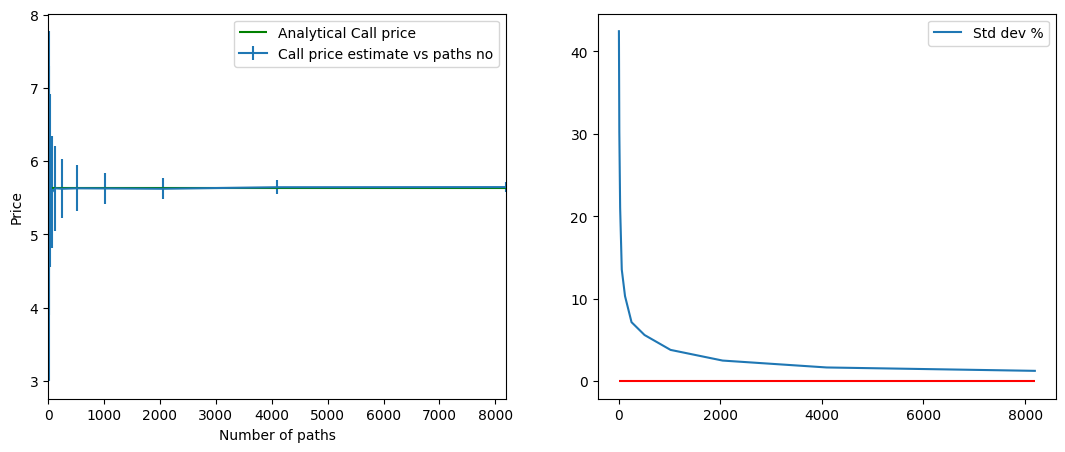

In [ ]:
print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, sigma = {sigma:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}')
fig,ax = plt.subplots(1,2, figsize=(13,5))
ax[0].errorbar(pathsArray, callPriceResults, yerr = callStdDevResults, label = "Call price estimate vs paths no")
ax[0].hlines(y=BSMcall(S0, K, T, t, r, q, sigma), xmin =0, xmax = np.power(2,pf), colors = 'green', label = "Analytical Call price")
ax[0].legend()
ax[0].set_xlim(0,np.power(2,pf-1))
ax[0].set_xlabel('Number of paths')
ax[0].set_ylabel('Price')
ax[1].plot(pathsArray, callStdDevResults*100/BSMcall(S0, K, T, t, r, q, sigma), label = "Std dev %")
ax[1].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,pf-1))
ax[1].legend()
fig.show()
print(f'The lowest std dev of {callStdDevResults[-1]*100/BSMcall(S0, K, T, t, r, q, sigma):.2f} % is achieved for { np.power(2,pf-1)} trajectories')

Clearly, the error is in an acceptable range after averaging over $2^{13} \approx 8000$ trajectories

We shall use $2^{13}$ trajectories to work out the price estimates for the Put, Digital Call Digital Put, Firward Price and Zero Coupon Bond

In [ ]:
startTime = time()
putArray = np.zeros(Nexp)
digitalCallArray = np.zeros(Nexp)
digitalPutArray = np.zeros(Nexp)
forwardPriceArray = np.zeros(Nexp)
zeroCouponBondArray = np.zeros(Nexp)
n = np.power(2,pf-1)
for i in range(0,Nexp):
    _S = OneDGBMPathGenerator(n,S0,T-t,r,q,sigma)
    putArray[i] = MonteCarloPut(_S,K, T, t, 0)
    digitalCallArray[i] = MonteCarloDigitalCall(_S,K, T, t, 0)
    digitalPutArray[i] = MonteCarloDigitalPut(_S,K, T, t, 0)
    forwardPriceArray[i] = MonteCarloForwardPrice(_S,K, T, t, 0)
    zeroCouponBondArray[i] = MonteCarloZeroCouponBond(_S,K, T, t, 0)
print(f'The time taken to reach accuracy of {np.std(putArray)*100/BSMput(S0,K, T, t ,r ,q, sigma):.2f}% using the 1dim Monte Carlo approach is {time() - startTime:.2f} s')

The time taken to reach accuracy of 2.10% using the 1dim Monte Carlo approach is 0.10 s


In [ ]:
_putDiscrepancy = (np.mean(putArray) - BSMput(S0, K, T, t, r, q, sigma))/BSMput(S0, K, T, t, r, q, sigma)
print(f'The discrepancy between the Monte Carlo Put and the analytical formula is {_putDiscrepancy*100:.2f} %')

The discrepancy between the Monte Carlo Put and the analytical formula is 0.07 %


In [ ]:
_digitalCallDiscrepancy = (np.mean(digitalCallArray) - BSMdigitalCall(S0, K, T, t, r, q, sigma))/BSMdigitalCall(S0, K, T, t, r, q, sigma)
print(f'The discrepancy between the Monte Carlo Digital Call and the analytical formula is {_digitalCallDiscrepancy*100:.2f} %')

The discrepancy between the Monte Carlo Digital Call and the analytical formula is 0.00 %


In [ ]:
_digitalPutDiscrepancy = (np.mean(digitalPutArray) - BSMdigitalPut(S0, K, T, t, r, q, sigma))/BSMdigitalPut(S0, K, T, t, r, q, sigma)
print(f'The discrepancy between the Monte Carlo Digital Put and the analytical formula is {_digitalPutDiscrepancy*100:.2f} %')

The discrepancy between the Monte Carlo Digital Put and the analytical formula is -0.01 %


In [ ]:
_forwardPriceDiscrepancy = (np.mean(forwardPriceArray) - BSMforwardPrice(S0, K, T, t, r, q))/BSMforwardPrice(S0, K, T, t, r, q)
print(f'The discrepancy between the Monte Carlo Forward Price and the analytical formula is {_forwardPriceDiscrepancy*100:.2f} %')

The discrepancy between the Monte Carlo Forward Price and the analytical formula is -0.02 %


In [ ]:
_zeroCouponBondDiscrepancy = (np.mean(zeroCouponBondArray) - BSMzeroCouponBondPrice(T, t, r))/BSMzeroCouponBondPrice(T, t, r)
print(f'The discrepancy between the Monte Carlo Zero Coupon Bond and the analytical formula is {_zeroCouponBondDiscrepancy*100:.2f} %')

The discrepancy between the Monte Carlo Zero Coupon Bond and the analytical formula is 0.00 %


## Investigations

In [ ]:
T = np.random.uniform(0.01,5)
t = 0
S0 = np.random.uniform(20,100)
K = np.random.normal(S0,S0*5/100) # Draw a Gaussian distributed Strike price around initial stock price
# If the strike price is very far away from S0 we essentially explore a 0 value region for which the Monte Carlo approximations fail
r = np.random.uniform(0.001, 0.1) #risk free rate
q = 0
sigma = np.random.uniform(0.001, 0.3)
print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, sigma = {sigma:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}')

Using parameters: r = 0.03, q = 0.00, sigma = 0.25, t = 0.00 years, T = 4.45 years, S0 = 31.38, K = 31.68


### Call option price vs volatility

Using parameters: r = 0.03, q = 0.00, t = 0.00, T = 4.45 years, K = 31.68


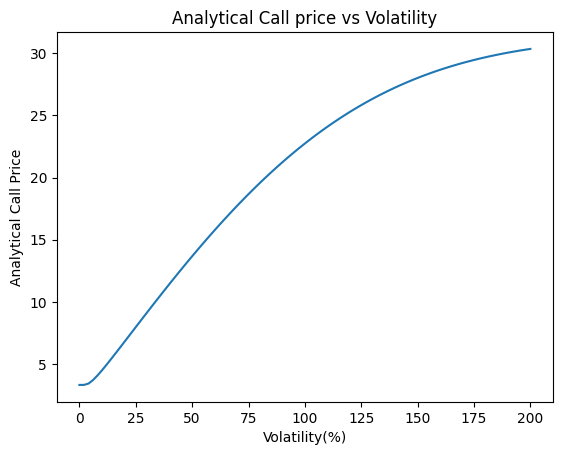

In [ ]:
N = 100
maxSigma = 2 # 200% yearly vol
sigmaVec = np.linspace(0.0001,maxSigma,N)
callvVol = BSMcall(S0, K, T, t, r, q, sigmaVec)
print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, t = {t:.2f}, T = {T:.2f} years, K = {K:.2f}')
plt.plot(sigmaVec*100, callvVol)
plt.xlabel('Volatility(%)')
plt.ylabel('Analytical Call Price')
plt.title('Analytical Call price vs Volatility')
plt.show()

### Digital Call Price vs volatility

Using parameters: S0 : 31.37743355887853, r = 0.03, q = 0.00, t = 0.00, T = 4.45 years, K = 31.68, sigma = 25.10 %


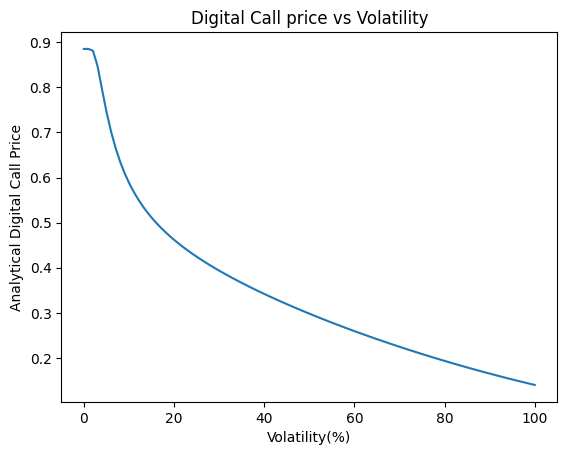

In [ ]:
N = 100
maxSigma = 1 # 200% yearly vol
sigmaVec = np.linspace(0.000001,maxSigma,N)
callvVol = BSMdigitalCall(S0, K, T, t, r, q, sigmaVec)
print(f'Using parameters: S0 : {S0}, r = {r:.2f}, q = {q:.2f}, t = {t:.2f}, T = {T:.2f} years, K = {K:.2f}, sigma = {sigma*100:.2f} %')
plt.plot(sigmaVec*100, callvVol)
plt.xlabel('Volatility(%)')
plt.ylabel('Analytical Digital Call Price')
plt.title('Digital Call price vs Volatility')
plt.show()

### At the money call option vs volatility

Using parameters: r = 0.03, q = 0.00, t = 0.00, T = 4.45 years, K = 31.68


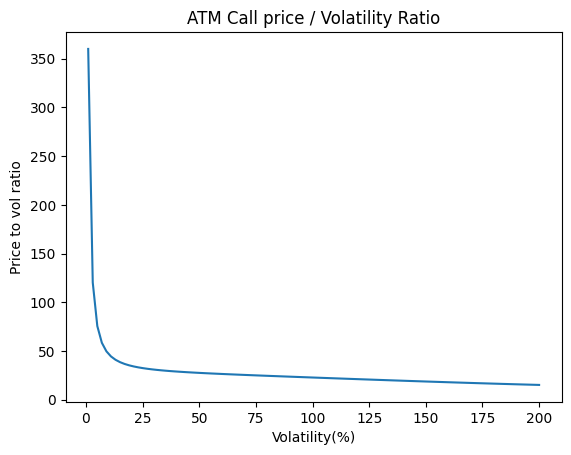

In [ ]:
N = 100
maxSigma = 2 # 200% yearly vol
sigmaVec = np.linspace(0.01,maxSigma,N)
callvVol = BSMcall(S0, S0, T, t, r, q, sigmaVec)/sigmaVec
print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, t = {t:.2f}, T = {T:.2f} years, K = {K:.2f}')
plt.plot(sigmaVec*100, callvVol)
plt.xlabel('Volatility(%)')
plt.ylabel('Price to vol ratio')
plt.title('ATM Call price / Volatility Ratio')
plt.show()

### Put option price and intrinsic value ($K-S_0$)

Using parameters: r = 0.05, q = 0.00, sigma = 10.0 %,  t = 0.00, T = 5.00 years, S0 = 100, K = 103.00


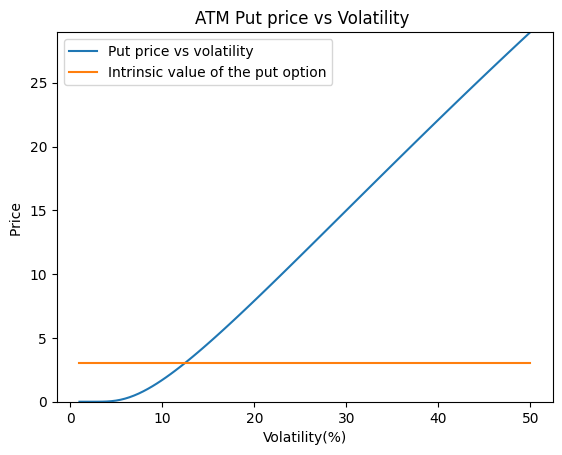

In [ ]:
t = 0 ; T = 5 ; K = 103 ; q = 0.0 ; sigma = .1 ; r = .05 ; S0 = 100 ; N = 100
maxSigma = .5
sigmaVec = np.linspace(0.01,maxSigma,N)
putvVol = BSMput(S0, K, T, t, r, q, sigmaVec)
print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, sigma = {sigma*100} %,  t = {t:.2f}, T = {T:.2f} years, S0 = {S0}, K = {K:.2f}')
plt.plot(sigmaVec*100, putvVol, label= 'Put price vs volatility')
plt.plot(sigmaVec*100, np.ones(N)*(K-S0), label = 'Intrinsic value of the put option') # Intrinsic value
plt.ylim(0,np.max(putvVol))
plt.xlabel('Volatility(%)')
plt.ylabel('Price ')
plt.title('ATM Put price vs Volatility ')
plt.legend()
plt.show()

## Testing the Multi dimensional GBM path generator
The process is simulated with step size $\Delta t = T/2^{i}$ where $2^i$ also represents the number of trajectories simulated

$$S_{(j+1)\Delta T} = S_{j\Delta T} + rS_{j\Delta T} \Delta T + \sigma S_{j\Delta T} \sqrt{\Delta T} W_j$$

In [ ]:
pi = 3 # initial power of 2 for no of paths
pf = 12 # final power of 2
Nexp = 50 # number of experiments for given path no
pathsArray = np.power(2,np.arange(pi,pf))
callArray = np.zeros(shape=(pf-pi,Nexp))

In [ ]:
for idx,i in enumerate(range(pi,pf)):
    n = np.power(2,i)
    for j in range(0,Nexp):
        S = GBMPathGenerator(n,n,S0,T,r,q,sigma)
        callArray[idx,j] = MonteCarloCall(S,K, T, t)

In [ ]:
callPriceResults = np.mean(callArray, axis = 1)
callStdDevResults = np.std(callArray, axis = 1)

Using parameters: r = 0.05, q = 0.00, t = 0.00, sigma = 0.10, T = 5.00 years, K = 103.00
The lowest std dev of 1.77 % is achieved for 2048 trajectories


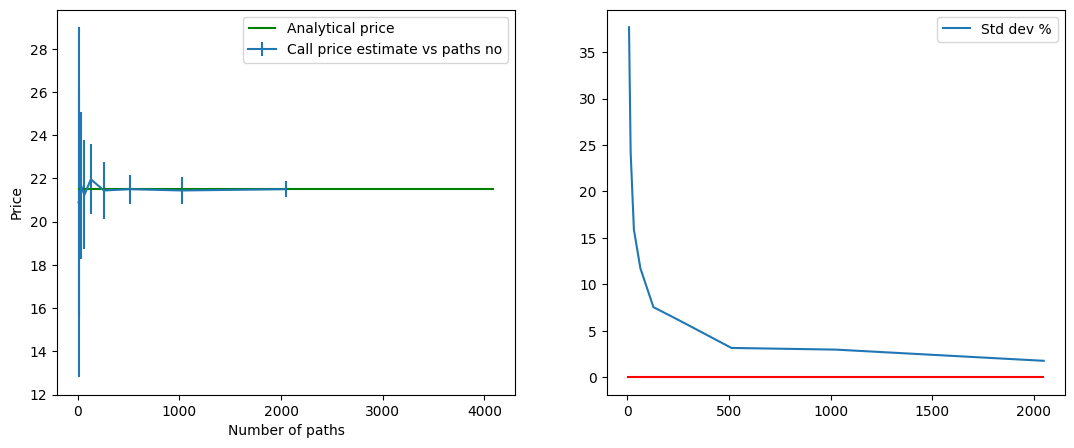

In [ ]:
print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, t = {t:.2f}, sigma = {sigma:.2f}, T = {T:.2f} years, K = {K:.2f}')
fig,ax = plt.subplots(1,2, figsize=(13,5))
ax[0].errorbar(pathsArray, callPriceResults, yerr = callStdDevResults, label = "Call price estimate vs paths no")
ax[0].hlines(y=BSMcall(S0, K, T, t, r, q, sigma), xmin =0, xmax = np.power(2,pf), colors = 'green', label = "Analytical price")
ax[0].legend()
#ax[0].set_xlim(0,np.power(2,pf-1))
ax[0].set_xlabel('Number of paths')
ax[0].set_ylabel('Price')
ax[1].plot(pathsArray, callStdDevResults*100/BSMcall(S0, K, T, t, r, q, sigma), label = "Std dev %")
ax[1].hlines(y=0, color = 'red', xmin =0, xmax = np.power(2,pf-1))
ax[1].legend()
fig.show()
print(f'The lowest std dev of {callStdDevResults[-1]*100/BSMcall(S0, K, T, t, r, q, sigma):.2f} % is achieved for { np.power(2,pf-1)} trajectories')

In [ ]:
startTime = time()
n = np.power(2,pf-1)
callArray = np.zeros(Nexp)
for i in range(0,Nexp):
    S = GBMPathGenerator(n,n,S0,T,r,q,sigma)
    callArray[i] = MonteCarloCall(S,K, T, t)
print(f'The time taken to reach accuracy of {np.std(callArray)*100/BSMcall(S0, K, T, t, r, q, sigma):.2f} % using multi dimensional Monte Carlo is {time()-startTime:.2f} s')

The time taken to reach accuracy of 2.10 % using multi dimensional Monte Carlo is 22.41 s
